In [1]:
import csv
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas as pd
from src.modules import ExternalMarket

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({"font.size": 10})
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# plt.rcParams["axes.facecolor"] = "#f5f5f5"
plt.rcParams["grid.color"] = "white"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.linewidth"] = 2

In [2]:
with open("../data/slippage/eth_usdc_0_3.csv", "r") as infile:
    eth_usdc_0_3_data = pd.read_csv(infile)
# with open("../data/slippage/eth_usdc_0_05.csv","r") as infile: eth_usdc_0_05_data = pd.read_csv(infile)
# with open("../data/slippage/usdct_usdt_0_01.csv","r") as infile: usdct_usdt_0_01_data = pd.read_csv(infile)
# with open("../data/slippage/dai_usdc_0_01.csv","r") as infile: dai_usdc_0_01_data = pd.read_csv(infile)

In [44]:
# TODO need to productionalize this so we can feed in a standard
# format of trades, and output regression parameters.


def get_coinbase_prices(uni_df, fn, vol_window=30):
    with open("", "r") as infile:
        eth_usdc_price_data = pd.read_csv(infile)

    eth_usdc_price_data.sort_values(
        by="unix_timestamp",
        axis=0,
        ascending=True,
        inplace=True,
        kind="quicksort",
        na_position="last",
    )
    eth_usdc_price_data["date"] = pd.to_datetime(
        eth_usdc_price_data["unix_timestamp"], unit="s"
    ).dt.date
    daily_eth_usdc_price_data = eth_usdc_price_data.groupby(["date"]).agg(
        {"unix_timestamp": ["first", "last"], "close": ["mean", "std"]}
    )
    daily_eth_usdc_price_data_reset = daily_eth_usdc_price_data.reset_index()
    daily_eth_usdc_price_data_reset.columns = [
        "_".join(col).rstrip("_")
        for col in daily_eth_usdc_price_data_reset.columns.values
    ]
    daily_eth_usdc_price_data_reset = daily_eth_usdc_price_data_reset.rename(
        columns={"close_std": "volatility", "close_mean": "mean_price"}
    )
    daily_eth_usdc_price_data_reset["volatility"] = (
        daily_eth_usdc_price_data_reset["volatility"]
        / daily_eth_usdc_price_data_reset["mean_price"]
    ) * ((365**0.5))
    daily_eth_usdc_price_data_reset[
        "rolling_volatility"
    ] = daily_eth_usdc_price_data_reset["volatility"].rolling(
        window=vol_window
    ).mean() * (
        (365**0.5)
    )
    daily_eth_usdc_price_data_reset.dropna(inplace=True)

    cb_uni_merge = pd.merge_asof(
        uni_df,
        daily_eth_usdc_price_data_reset,
        left_on="unix_timestamp",
        right_on="unix_timestamp_first",
        direction="backward",
    )
    cb_uni_merge.rename(
        columns={
            "date_x": "date",
            "rolling_volatility_x": "rolling_volatility",
            "trade_size": "trade_size",
        },
        inplace=True,
    )
    return cb_uni_merge


# token0 is usdc, token1 is eth
def process_trades(df, decimals, vol_window=30):
    """
    TODO write a script that gets the trades from theGraph or
    similar API. Perform necessary decimal adjustments without
    hard-coding.
    """
    # if type=="collateral":
    #     df["trade_size_x"]=df["amount1_adjusted"].apply(lambda x: (x/1.0e12))
    #     df["trade_size_y"]=df["amount0_adjusted"].apply(lambda x: (x*1.0e12))
    #     df["price_implied"] = 1e24/df["price_implied"]
    #     df["price_actual"] = 1e24/df["price_actual"]
    #     df["previous_price_actual"] = 1e24/df["previous_price_actual"]
    # else:
    #     df["trade_size_x"]=df["amount1_adjusted"].apply(lambda x: (x))
    #     df["trade_size_y"]=df["amount0_adjusted"].apply(lambda x: (x))
    #     df["price_implied"] = df["price_implied"]
    #     df["price_actual"] = df["price_actual"]
    #     df["previous_price_actual"] = df["previous_price_actual"]
    df = df.copy()  # TODO just for testing to avoid mutating orig df

    price_cols = ["price_implied", "price_actual", "previous_price_actual"]

    # NOTE these adjustments are stupid, the data is coming in wrong.
    # The amounts should be adhering to the decimals of each token.
    # Instead, the amounts are just all fucked up.

    # Make sure price is token_out for token_in instead of
    # amount0 for amount1
    cond = df["amount1_adjusted"] < 0
    for col in price_cols:
        df.loc[cond, col] = df.loc[cond, col].apply(lambda x: x / 10 ** sum(decimals))
        df.loc[~cond, col] = df.loc[~cond, col].apply(
            lambda x: 1 / x * 10 ** sum(decimals)
        )

    df["amount0_adjusted"] *= 10 ** (decimals[0] - decimals[1])
    df["amount1_adjusted"] /= 10 ** (decimals[0] - decimals[1])

    df["price_impact"] = (df["price_implied"] - df["previous_price_actual"]) / (
        df["previous_price_actual"]
    )

    df["evt_block_time"] = pd.to_datetime(df["evt_block_time"], utc=True)
    df["unix_timestamp"] = df["evt_block_time"].astype(int) // 10**9
    df.sort_values(
        by="unix_timestamp",
        axis=0,
        ascending=True,
        inplace=True,
        kind="quicksort",
        na_position="last",
    )
    df["date"] = pd.to_datetime(df["unix_timestamp"], unit="s").dt.date

    return df[df["amount0_adjusted"] > 0], df[df["amount0_adjusted"] < 0]


def plot_stats(merged_df, name, type="collateral"):
    print(merged_df.columns, merged_df.shape)

    plt.figure()
    # plt.plot(merged_df["date"],merged_df["std_price"]/merged_df["price_actual_mean"], label='std_price')
    plt.plot(
        merged_df["date"], merged_df["rolling_volatility"], label="rolling_volatility"
    )
    plt.scatter(
        merged_df["date"],
        merged_df["price_impact"],
        label="price_impact",
        alpha=0.1,
        c=merged_df["trade_size_x"],
        cmap="viridis",
    )
    plt.legend()
    plt.title(name)
    cbar = plt.colorbar()
    cbar.set_label("Trade Size")
    plt.show()

    ##############################################
    print(merged_df[["price_impact", "trade_size_x"]])
    plt.figure()
    plt.plot(
        merged_df["date"], merged_df["rolling_volatility"], label="rolling_volatility"
    )
    ax2 = plt.twinx()
    scatter = ax2.scatter(
        merged_df["date"],
        100 * merged_df["price_impact"] / merged_df["trade_size_x"],
        label="price_impact/trade_size",
        alpha=0.1,
        c=merged_df["rolling_volatility"],
        cmap="viridis",
    )
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label("Rolling Volatility")
    plt.title(name)
    handles1, labels1 = plt.gca().get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2
    plt.legend()
    plt.show()

    plt.figure()
    plt.scatter(
        merged_df["trade_size_x"],
        merged_df["price_impact"],
        c=merged_df["rolling_volatility"],
        cmap="viridis",
    )
    plt.title(name)
    plt.show()

    plt.figure()
    plt.plot(merged_df["unix_timestamp"], merged_df["price_actual"])
    plt.title(name)
    plt.show()
    return merged_df


def regress(df, x_vars, y_var, v=False):
    X = sm.add_constant(df[x_vars])
    y = df[y_var]
    model = sm.OLS(y, X).fit()
    if v:
        print(model.summary())
    return model


def lin_reg(
    df,
    x_var="trade_size_x",
    y_var="price_impact",
    name=None,
    color_var="rolling_volatility",
):
    print("lin_reg")
    # Linear regression
    # Generate Y-values based on the regression model
    p, cov = np.polyfit(
        df[x_var], df[y_var], 1, cov=True
    )  # Assuming x and y are your data arrays
    slope = p[0]
    intercept = p[1]
    errors = np.sqrt(np.diag(cov))
    y_fit = slope * df[x_var] + intercept
    print(slope, intercept, errors)
    plt.scatter(x=df[x_var], y=df[y_var], label="Data", c=df[color_var], cmap="viridis")
    plt.plot(
        df[x_var],
        y_fit,
        label=f"Fit: y = {slope:.6f}x + {intercept:.6f}",
        color="firebrick",
    )
    if x_var == "trade_size_x":
        plt.xlabel("Trade Size")
    else:
        plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.legend()
    plt.title(name)
    cbar = plt.colorbar()
    cbar.set_label(color_var)
    plt.show()
    return (p, cov)


def plot_3d_relationships(df, x_var, y_var, z_var):
    if x_var == "amount1_adjusted":
        x_var_name = "Trade Size"
        df[x_var + "_bin"] = df[x_var].round()
    else:
        x_var_name = y_var
        df[x_var + "_bin"] = df[x_var].round(2)

    df[y_var + "_bin"] = df[y_var].round(4)
    df[z_var + "_bin"] = df[z_var].round(0)

    df2 = (
        df.groupby([x_var + "_bin", y_var + "_bin"]).agg({z_var: "mean"}).reset_index()
    )
    fig = px.scatter(df2, x=x_var + "_bin", y=z_var, color=y_var + "_bin")
    fig.update_layout(
        xaxis=dict(type="linear", title=x_var_name + "_bin"),
        yaxis=dict(type="linear", title=z_var),
        title_text=x_var_name + "_bin vs " + z_var,
    )
    fig.show()

    df3 = (
        df.groupby([y_var + "_bin", x_var + "_bin"]).agg({z_var: "mean"}).reset_index()
    )
    fig = px.scatter(df3, x=y_var + "_bin", y=z_var, color=x_var + "_bin")
    fig.update_layout(
        xaxis=dict(type="linear", title=y_var + "_bin"),
        yaxis=dict(type="linear", title=z_var),
        title_text=y_var + "_bin vs " + z_var,
    )
    fig.show()

In [45]:
# eth_usdc_0_05_df = process_trades(eth_usdc_0_05_data,vol_window=7,type="collateral")
# usdct_usdt_0_01_df = process_trades(usdct_usdt_0_01_data,vol_window=30,type="stables")
# dai_usdc_0_01_df = process_trades(dai_usdc_0_01_data,vol_window=30,type="stables")

In [54]:
# df0 has token 0 being sold, df1 has token 1 being sold
df0, df1 = process_trades(eth_usdc_0_3_data, [18, 6], vol_window=7)

coefs = np.zeros((2, 2))
intercepts = np.zeros((2, 2))
results = np.zeros((2, 2))

ols = regress(df0, x_vars=["amount0_adjusted"], y_var=["price_impact"], v=False)
b, m = ols.params
coefs[0][1] = m
intercepts[0][1] = b
results[0][1] = ols.rsquared_adj

ols = regress(df1, x_vars=["amount1_adjusted"], y_var=["price_impact"], v=False)
b, m = ols.params
coefs[1][0] = m
intercepts[1][0] = b
results[1][0] = ols.rsquared_adj

coefs, intercepts, results

(array([[ 0.00000000e+00, -2.82545974e-09],
        [-3.97739956e-06,  0.00000000e+00]]),
 array([[ 0.        , -0.00300451],
        [-0.00301359,  0.        ]]),
 array([[0.        , 0.91565548],
        [0.86055151, 0.        ]]))

In [57]:
df = df0
market = ExternalMarket(2, coefs, intercepts)
df["predicted"] = df.apply(
    lambda row: -market.trade(
        row["amount0_adjusted"], row["previous_price_actual"], 0, 1
    ),
    axis=1,
)
df["pct_error"] = df.apply(
    lambda row: -abs(row["amount1_adjusted"] - row["predicted"])
    / row["amount1_adjusted"]
    * 100,
    axis=1,
)
print(f"Mean percentage error: {df['pct_error'].mean()}%")
df.head()

Mean percentage error: 0.0039027607290628838%


,amount0_adjusted,amount1_adjusted,price_implied,price_actual,previous_price_actual,price_movement_percentage,evt_tx_hash,evt_block_number,evt_block_time,evt_index,price_impact,unix_timestamp,date,predicted,pct_error
0,40.043899,-0.024662,0.000616,0.000618,0.000618,-1.754502e-07,0x584b5fcd75589d61ccf46fdd9611b4fcb95ea01fe7fd...,15868258.0,2022-10-31 13:11:47+00:00,67,-0.003000,1667221907,2022-10-31,-0.024662,0.000454
1,3126.994673,-1.925851,0.000616,0.000618,0.000618,-1.370062e-05,0xc06ed09aa8ee6aefc26cf27bb49597d9a78da314d19c...,15868259.0,2022-10-31 13:11:59+00:00,187,-0.003007,1667221919,2022-10-31,-1.925839,0.000653
2,811.022521,-0.499488,0.000616,0.000618,0.000618,-3.553418e-06,0x3461e21c25bd5d48792fb382c2b6edf11fcd5cfd9a1e...,15868279.0,2022-10-31 13:15:59+00:00,166,-0.003002,1667222159,2022-10-31,-0.499485,0.000504
3,253801.883288,-156.222856,0.000616,0.000617,0.000618,-1.111083e-03,0xfc90fbf6f13106ccc2201630c8666bc93036823b6ebf...,15868285.0,2022-10-31 13:17:11+00:00,5,-0.003554,1667222231,2022-10-31,-156.196582,0.016818
4,596.667082,-0.367062,0.000615,0.000617,0.000617,-2.612784e-06,0xeeac0325bd17bdfede8e78c0c0b50fe9d13df618b61c...,15868288.0,2022-10-31 13:17:47+00:00,116,-0.003001,1667222267,2022-10-31,-0.367061,0.000490


In [62]:
df = df1
market = ExternalMarket(2, coefs, intercepts)
df["predicted"] = df.apply(
    lambda row: -market.trade(
        row["amount1_adjusted"], row["previous_price_actual"], 1, 0
    ),
    axis=1,
)
df["pct_error"] = df.apply(
    lambda row: -abs(row["amount0_adjusted"] - row["predicted"])
    / row["amount0_adjusted"]
    * 100,
    axis=1,
)
print(f"Mean percentage error: {df['pct_error'].mean()}%")
df.head()

Mean percentage error: 0.005584172381012744%


,amount0_adjusted,amount1_adjusted,price_implied,price_actual,previous_price_actual,price_movement_percentage,evt_tx_hash,evt_block_number,evt_block_time,evt_index,price_impact,unix_timestamp,date,predicted,pct_error
8,-613.997881,0.380000,1615.783897,1620.643650,1620.648021,2.696770e-06,0x70738bf4e0f99d43ceb1ec1a57083ec3f5989d4bb347...,15868358.0,2022-10-31 13:31:47+00:00,183,-0.003001,1667223107,2022-10-31,-613.989407,0.001380
9,-206936.864777,128.130519,1615.047430,1619.170987,1620.643650,9.095170e-04,0x42b9c7de9958051cb08506e0b04b21945c43e60150c6...,15868363.0,2022-10-31 13:32:47+00:00,5,-0.003453,1667223167,2022-10-31,-206922.301199,0.007038
10,-372232.540604,230.771294,1612.993254,1616.523684,1619.170987,1.637652e-03,0x7e80ddb521d28907dbdfb4a633ad1e0a879c198584e4...,15868364.0,2022-10-31 13:32:59+00:00,5,-0.003815,1667223179,2022-10-31,-372189.161009,0.011654
11,-76380.697092,47.400000,1611.407112,1615.988119,1616.523684,3.314164e-04,0xe9775537c82ff2bffd46f22de7d19f10a863e0fc74bb...,15868364.0,2022-10-31 13:32:59+00:00,294,-0.003165,1667223179,2022-10-31,-76377.865750,0.003707
12,-48.334199,0.030000,1611.139967,1615.987780,1615.988119,2.097051e-07,0x8be6ac83d49e172350467e27485401e2a183c5a524f4...,15868366.0,2022-10-31 13:33:23+00:00,132,-0.003000,1667223203,2022-10-31,-48.333540,0.001364


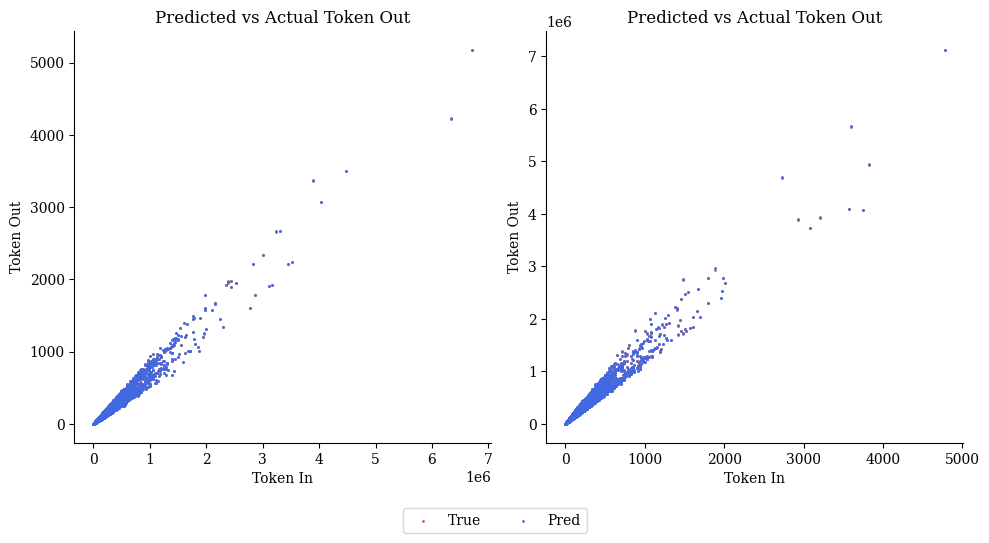

In [68]:
def plot_predictions(df0, df1):
    f, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].scatter(
        df0["amount0_adjusted"],
        -df0["amount1_adjusted"],
        label="True",
        c="indianred",
        s=1,
    )
    axs[0].scatter(
        df0["amount0_adjusted"], -df0["predicted"], label="Pred", c="royalblue", s=1
    )
    axs[0].set_xlabel("Token In")
    axs[0].set_ylabel("Token Out")

    axs[1].scatter(
        df1["amount1_adjusted"], -df1["amount0_adjusted"], c="indianred", s=1
    )
    axs[1].scatter(df1["amount1_adjusted"], -df1["predicted"], c="royalblue", s=1)
    axs[1].set_xlabel("Token In")
    axs[1].set_ylabel("Token Out")

    f.legend(loc="upper center", bbox_to_anchor=(0.5, 0), ncol=2)
    f.tight_layout()

    axs[0].set_title("Predicted vs Actual Token Out")
    axs[1].set_title("Predicted vs Actual Token Out")

    # if fn:
    #     plt.savefig(fn, dpi=300)
    #     plt.close()  # don't show


plot_predictions(df0, df1)

In [108]:
eth_usdc_0_3_df["date"].min(), eth_usdc_0_3_df["date"].max(),

(datetime.date(2022, 10, 31), datetime.date(2023, 10, 26))

In [ ]:
ols = gen_multi_var_reg(
    eth_usdc_0_3_df, x_vars=["trade_size_x"], y_var=["price_impact"], v=True
)

In [ ]:
def plot_price_impact(df, name, cmap="viridis", fn=None):
    ols = gen_multi_var_reg(df, x_vars=["trade_size_x"], y_var=["price_impact"])

    f, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(
        df["trade_size_x"],
        df["price_impact"] * 100,
        c=df["rolling_volatility"],
        s=10,
        cmap=cmap,
    )
    f.colorbar(
        plt.cm.ScalarMappable(cmap=cmap), ax=ax, label="Normalized Rolling Volatility"
    )

    b, m = ols.params
    x = np.linspace(0, df["trade_size_x"].max())
    y = (m * x + b) * 100
    ax.plot(x, y, c="indianred", linestyle="--", lw=1)

    ax.set_ylabel("Price Impact %")
    ax.set_xlabel("Trade Size (ETH)")
    ax.set_title(f"Price Impact on {name}")

    f.tight_layout()

    if fn:
        plt.savefig(fn, bbox_inches="tight", dpi=300)
        plt.close()

    return f


plot_price_impact(
    eth_usdc_0_05_df,
    "WETH/USDC 0.5% Uni v3 Pool",
    fn="../figs/manual/price_impact_weth_usdc_0_5.png",
)

In [ ]:
plot_stats(merged_df=eth_usdc_0_05_df, name="eth_usdc_0_05", type="collateral")

In [ ]:
ols1 = gen_multi_var_reg(
    eth_usdc_0_05_df, x_vars=["trade_size_x"], y_var=["price_impact"]
)
intercept = ols1.params[0]  # This is the intercept (often denoted as 'b0')
slopes = ols1.params[
    1:
]  # These are the slopes (coefficients for the predictors, 'b1', 'b2', ...)
print("rsquared", ols1.rsquared)
print("rsquared_adj", ols1.rsquared_adj)
print("intercept", intercept)
print("slopes", slopes)

In [ ]:
ols1 = gen_multi_var_reg(
    eth_usdc_0_05_df, x_vars=["new_cross_impact"], y_var=["price_impact"]
)
intercept = ols1.params[0]  # This is the intercept (often denoted as 'b0')
slopes = ols1.params[
    1:
]  # These are the slopes (coefficients for the predictors, 'b1', 'b2', ...)
print("rsquared", ols1.rsquared)
print("rsquared_adj", ols1.rsquared_adj)
print("intercept", intercept)
print("slopes", slopes)

In [ ]:
ols1 = gen_multi_var_reg(
    eth_usdc_0_05_df,
    x_vars=["rolling_volatility", "amount1_adjusted"],
    y_var=["price_impact"],
)
intercept = ols1.params[0]  # This is the intercept (often denoted as 'b0')
slopes = ols1.params[
    1:
]  # These are the slopes (coefficients for the predictors, 'b1', 'b2', ...)
print("rsquared", ols1.rsquared)
print("rsquared_adj", ols1.rsquared_adj)
print("intercept", intercept)
print("slopes", slopes)

# p,cov = lin_reg(eth_usdc_0_05_df, x_var="amount1_adjusted", y_var="price_impact",name="Trade Size vs Price Impact",color_var="rolling_volatility")
# slope = p[0]
# intercept = p[1]
# errors = np.sqrt(np.diag(cov))
# y_fit = slope * eth_usdc_0_05_df["amount1_adjusted"] + intercept

# p,cov = lin_reg(eth_usdc_0_05_df, x_var="new_cross_impact", y_var="price_impact",name="Trade Size x Volatility vs Price Impact",color_var="unix_timestamp")
# slope = p[0]
# intercept = p[1]
# errors = np.sqrt(np.diag(cov))
# y_fit = slope * eth_usdc_0_05_df["new_cross_impact"] + intercept

In [ ]:
ols2 = gen_multi_var_reg(
    eth_usdc_0_3_df,
    x_vars=["rolling_volatility", "amount1_adjusted"],
    y_var=["price_impact"],
)
print(ols2)

In [ ]:
ols3 = gen_multi_var_reg(
    usdct_usdt_0_01_df,
    x_vars=["rolling_volatility", "amount1_adjusted"],
    y_var=["price_impact"],
)
print(ols3)

In [ ]:
ols4 = gen_multi_var_reg(
    dai_usdc_0_01_df,
    x_vars=["rolling_volatility", "amount1_adjusted"],
    y_var=["price_impact"],
)
print(ols4)

In [ ]:
lin_reg(
    eth_usdc_0_05_df,
    x_var="amount1_adjusted",
    y_var="price_impact",
    name=None,
    color_var="rolling_volatility",
)
lin_reg(
    eth_usdc_0_3_df,
    x_var="amount1_adjusted",
    y_var="price_impact",
    name=None,
    color_var="rolling_volatility",
)

lin_reg(
    usdct_usdt_0_01_df,
    x_var="amount1_adjusted",
    y_var="price_impact",
    name=None,
    color_var="rolling_volatility",
)
lin_reg(
    dai_usdc_0_01_df,
    x_var="amount1_adjusted",
    y_var="price_impact",
    name=None,
    color_var="rolling_volatility",
)

In [ ]:
lin_reg(
    eth_usdc_0_3_df,
    x_var="amount1_adjusted",
    y_var="new_cross_impact",
    name=None,
    color_var="rolling_volatility",
)
lin_reg(
    usdct_usdt_0_01_df,
    x_var="amount1_adjusted",
    y_var="new_cross_impact",
    name=None,
    color_var="rolling_volatility",
)
lin_reg(
    dai_usdc_0_01_df,
    x_var="amount1_adjusted",
    y_var="new_cross_impact",
    name=None,
    color_var="rolling_volatility",
)

In [ ]:
# plot_3d_relationships(eth_usdc_0_05_df)
plot_3d_relationships(eth_usdc_0_3_df)
plot_3d_relationships(usdct_usdt_0_01_df)
# plot_3d_relationships(dai_usdc_0_01_df)

In [ ]:
import plotly.express as px
import numpy as np


# new slippage function based on empirical analysis
def quad_output(x):
    """
    @notice calculate price impact when selling x or y to the open market.
    Assuming that we trade against Uniswap is a conservative assumption
    """
    a, b, c = (2.602424822058012e-10, 2.3009044333523045e-07, 0.0004613261845851614)
    return a * x**2 + b * x + c


x = np.logspace(-9, 5, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
y = [quad_output(x) for x in x]
fig = px.line(x=x, y=y)
fig.show()


def lin_output(x):
    return 1.081593506690093e-06 * x + 0.0004379110082802476


x = np.logspace(-9, 5, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
print(x)
y = [lin_output(x) for x in x]
fig = px.line(x=x, y=y)
fig.show()